In [249]:
# !pip install urllib2

In [250]:
# nltk.download('punkt')

In [1]:
from bs4 import BeautifulSoup, SoupStrainer
import requests
import pandas as pd
import re
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
# Load library
from nltk.corpus import stopwords

In [11]:
page = requests.get("https://www.udemy.com")

In [16]:
soup = BeautifulSoup(page.text)

In [2]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [62]:
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    '/*',
    # there may be more elements you don't want, such as "style", etc.
]

def extract_links(url, blacklist=[]):
    try:
        page = requests.get(url)
    except:
        return pd.DataFrame([(None, None)], columns=["Text", "URL"])
    data = page.text
    soup = BeautifulSoup(data)
    mylinks = []
    for link in soup.find_all('a'):
        mytext = ""
        if link.parent.name not in blacklist:
            span = link.find("span")
            if span is not None:
                if span.text != "":
                    mytext = span.text.strip()
            else:
                mytext = link.text.strip()
        myhref = link.get("href")
        if myhref is not None:
#             print(myhref)
            if myhref.startswith("/"):
                myhref = url + myhref
            if "$" not in mytext and "0" not in myhref and "#" not in myhref and mytext != "" and "mailto" not in myhref and "javascript" not in myhref and "adobe" not in myhref:
                mylinks.append((mytext, myhref))
    mylinks = pd.DataFrame(mylinks, columns=["Text", "URL"])
    return mylinks

In [63]:
def extract_sub_links(df, links, depth=2):
    for url in links:
        df = pd.concat(objs=[df, extract_links(url=url)], axis=0)
    df = df.drop_duplicates()
    if depth > 0:
        return extract_sub_links(df=df, links=df.URL, depth=depth-1)
    else:
        return df

In [64]:
def extract_text(url, blacklist, stop_words):
    output = ''
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t.strip())
    output = output.split(" ")
    tag_words = []
    comment = False
    for out in output:
        if out == "/*":
            comment = True
        if out == "*/":
            comment = False
        if not comment:
            regex = re.compile('[@_!#$%^&*()€"<>?/\|.©+=},{~:]')  
            if regex.search(out) == None and "\t" not in out and "\n" not in out and out != "" and len(out) > 2 and '–' not in out and "-" not in out and "\xa0" not in out and "\xad" not in out and not hasNumbers(out):
                tag_words.append(out.lower())
    tag_words = np.array([word for word in tag_words if word not in stop_words])
    return tag_words

In [65]:
def generate_tag_word_dict(url, blacklist, depth=1, sub=False, stem=False, save=""):
    ps = PorterStemmer()
    stop_words = stopwords.words('german') #+ ["allianz", "überblick"]
    df = extract_links(url=url, blacklist=blacklist)
    if sub:
        df = extract_sub_links(df=df, links=df.URL, depth=depth)
    df = df.dropna().drop_duplicates()
#     df = df[df['URL'].str.contains("allianz")].reset_index(drop=True)
    df = df.reset_index(drop=True)
    df["Words"] = df.apply(lambda r: [], axis=1)
    for i in range(df.shape[0]):
        tag_words = extract_text(url=df.URL[i], blacklist=blacklist, stop_words=stop_words)
        stemmed = []
        if stem:
            for w in tag_words:
                stemmed.append(ps.stem(w))
        else:
            stemmed = tag_words
        df.loc[i, "Words"] = stemmed
    if save != "":
        df.to_csv(path_or_buf=save+".csv", index=False)
    return df

In [66]:
def extract_freqs(df, plot=False, save=""):
    df_freq = pd.DataFrame([(None, None, None)], columns=["Word", "Freq", "Page"])
    for i in range(df.shape[0]):
        tag_words = df.loc[i, "Words"]
        page = df.loc[i, "Text"]
        fdist = FreqDist(tag_words)
        freq = pd.DataFrame(fdist.most_common(100), columns=["Word", "Freq"])
        freq = freq[freq.Freq > 3]
        freq["Page"] = page
        df_freq = pd.concat(objs=[df_freq, freq], axis=0)
        if plot:
            plt.figure(figsize=(6, 6))
            fdist.plot(30, cumulative=False)
            plt.show()
    if save != "":
        df_freq.to_csv(path_or_buf=save+".csv", index=False)
    return df_freq.dropna()

In [67]:
links = extract_links(url="https://www.huk.de", blacklist=blacklist)

In [69]:
df = generate_tag_word_dict(url="https://www.huk.de", blacklist=blacklist,
                            depth=1, sub=False, stem=False, save="text_url_word")

InvalidSchema: No connection adapters were found for 'tel:+49696655566'

In [ ]:
df_freq = extract_freqs(df=df, plot=False, save="frequencies")

In [ ]:
df

In [35]:
df_freq.groupby("Word").count().sort_values(by="Freq", ascending=False)

,Freq,Page
Word,,


Privatkunden


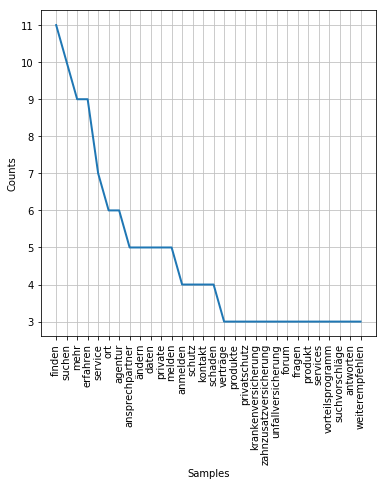

Firmenkunden


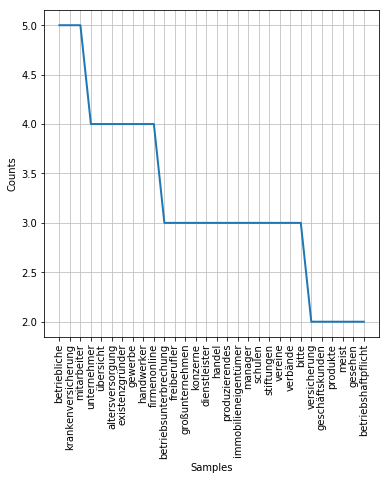

Registrieren


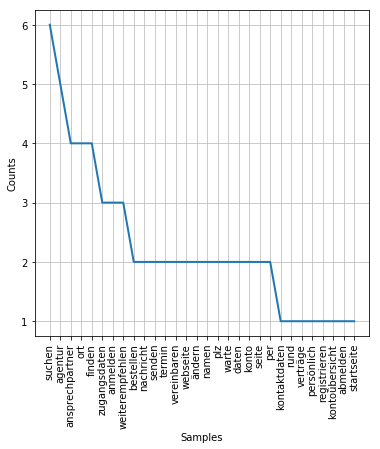

Kontoübersicht


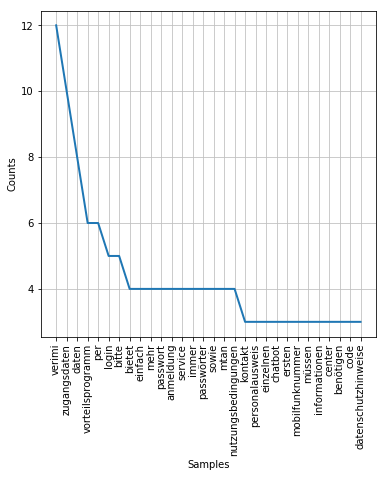

Kfz-Versicherung


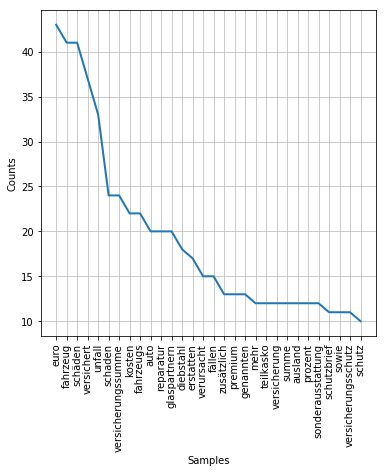

Schutzbrief


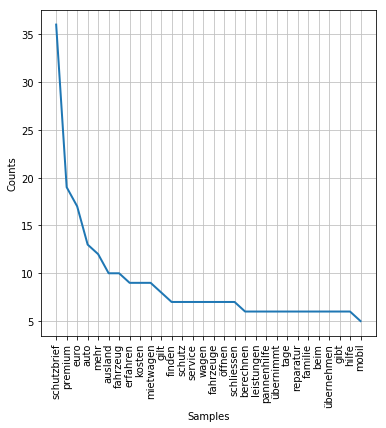

Oldtimerversicherung


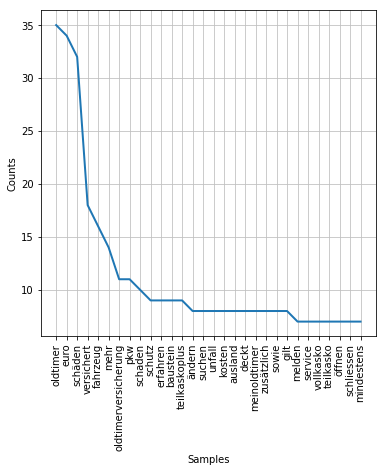

Motorradversicherung


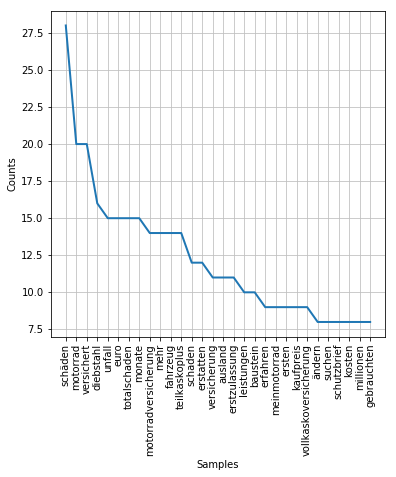

IM ÜBERBLICK


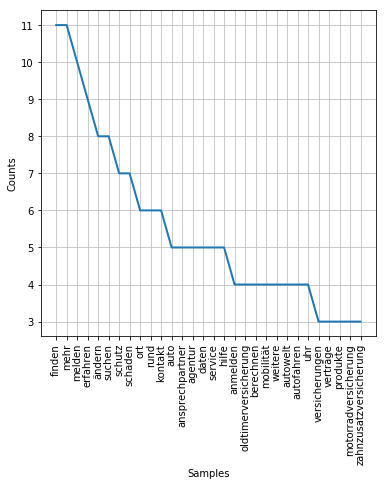

Hausratversicherung


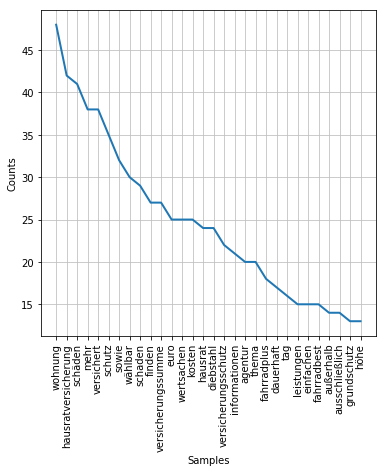

Wohngebäudeversicherung


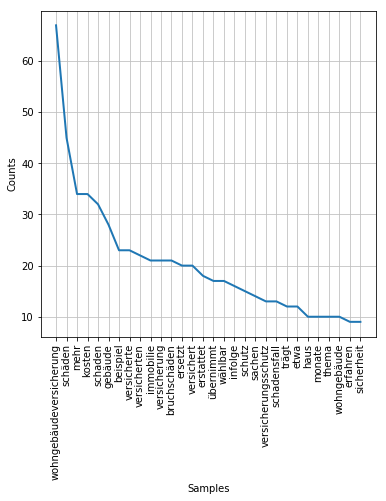

Haus-Haftpflicht


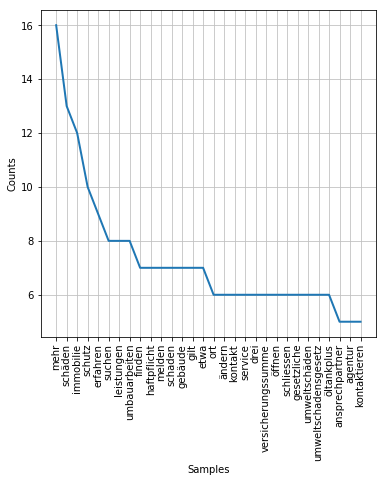

Baufinanzierung


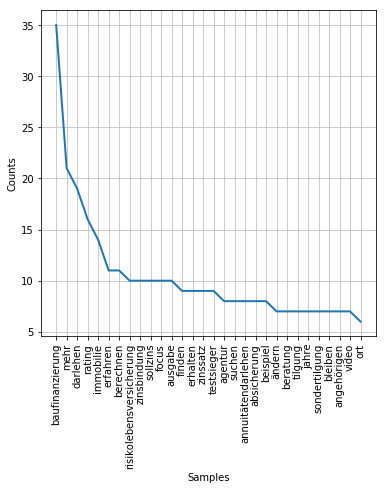

IM ÜBERBLICK


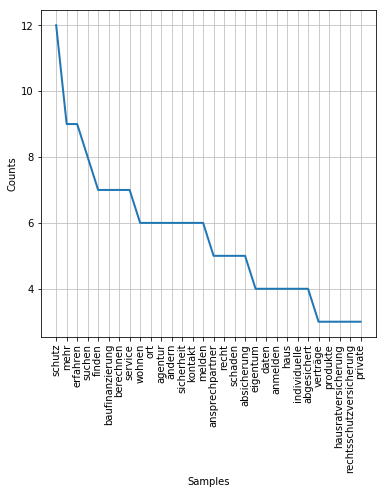

Privat-Haftpflicht


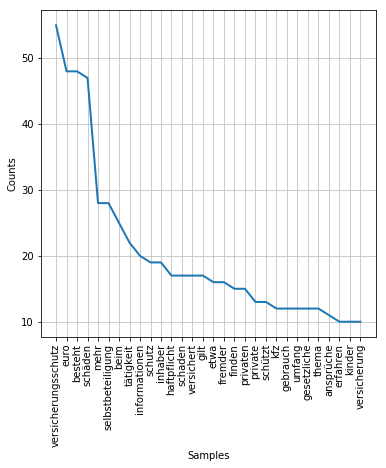

Hausrat-Haftpflicht Kombi


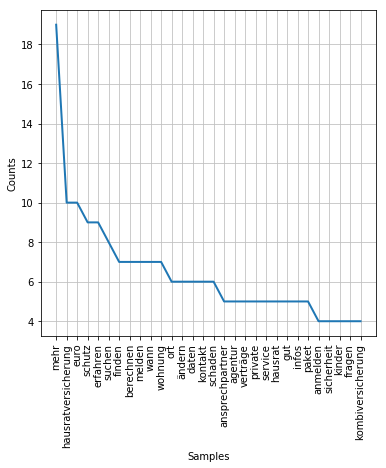

Tierhalter-Haftpflicht


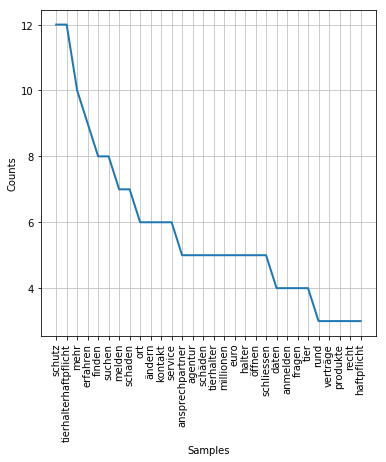

Rechtsschutzversicherung


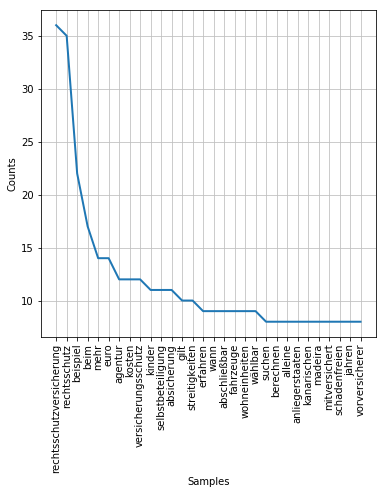

Verkehrsrechtsschutzversicherung


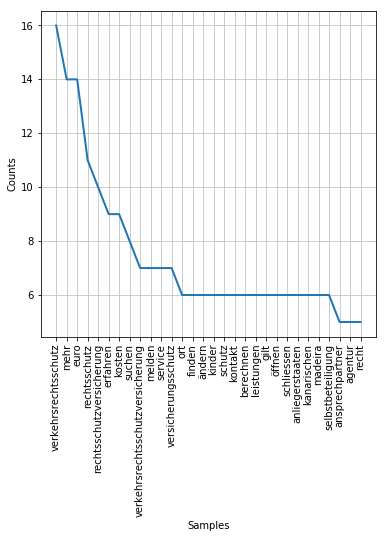

Private Krankenversicherung


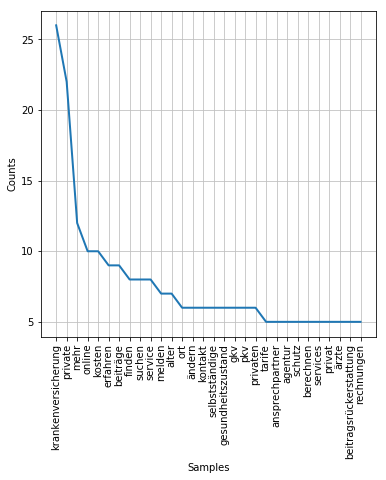

Krankenzusatzversicherung


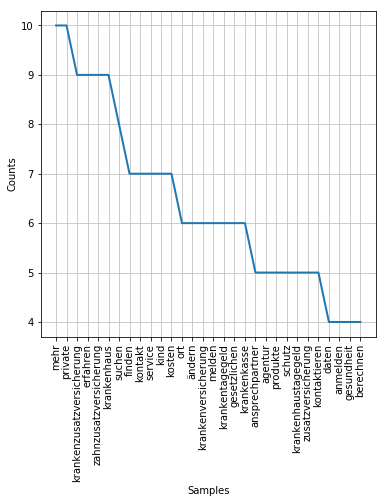

Krankenhauszusatzversicherung


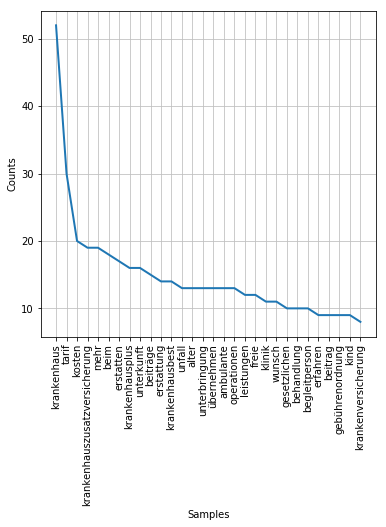

IM ÜBERBLICK


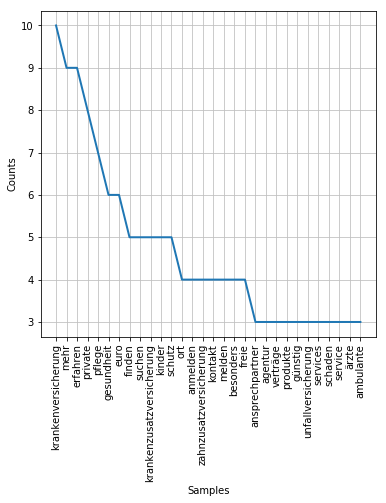

Zahnzusatzversicherung


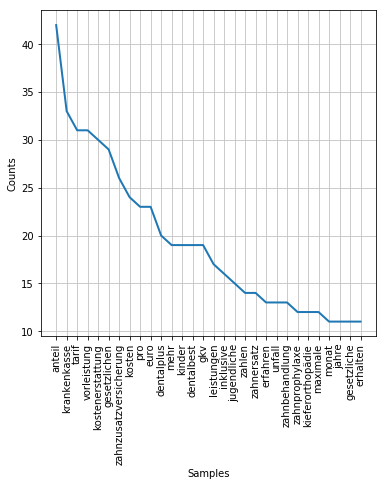

Zahnzusatzversicherung für Kinder


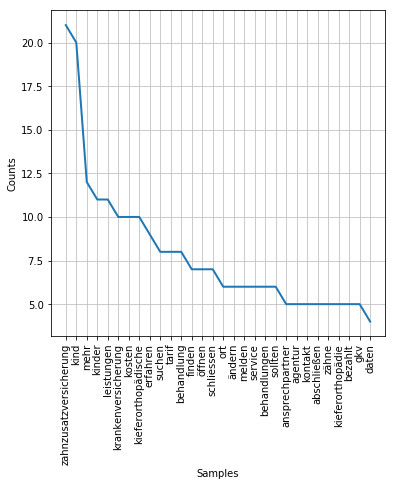

Pflegeversicherung


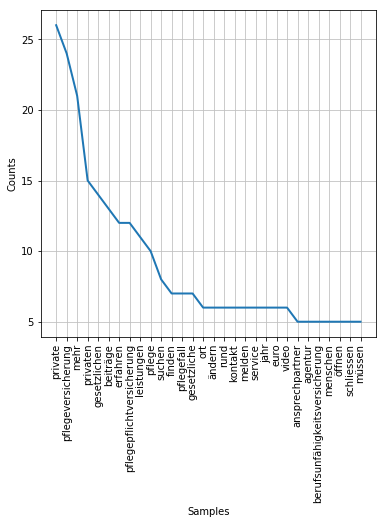

PflegeBahr


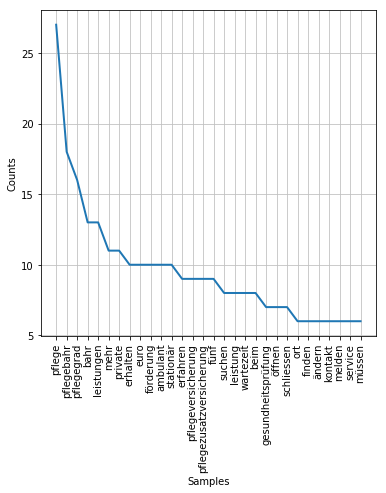

Pflegerentenversicherung


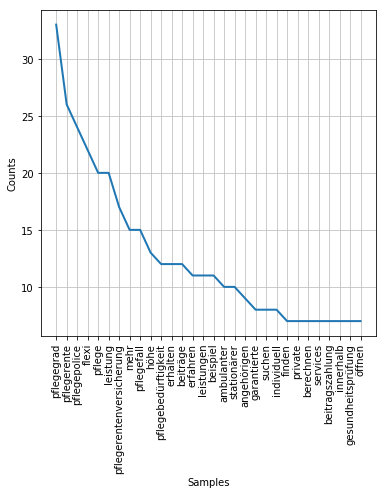

Pflegezusatzversicherung


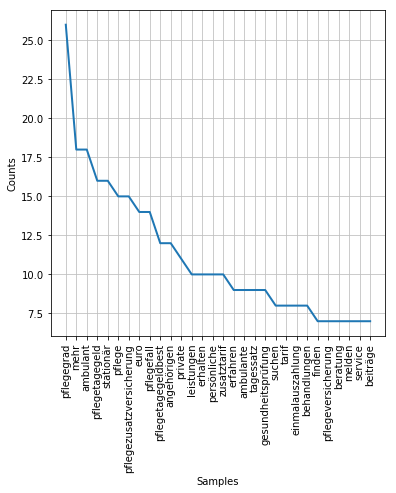

Katzenversicherung


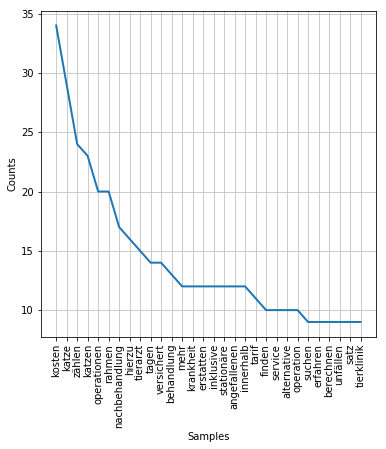

Hundekrankenversicherung


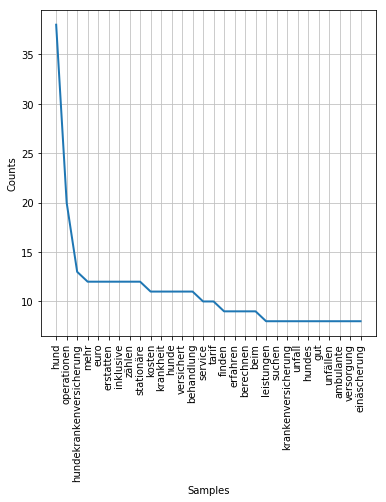

Pferde-OP-Versicherung


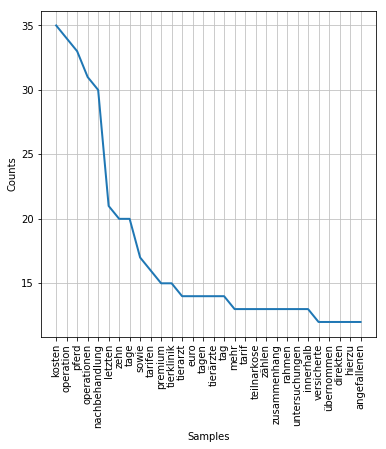

IM ÜBERBLICK


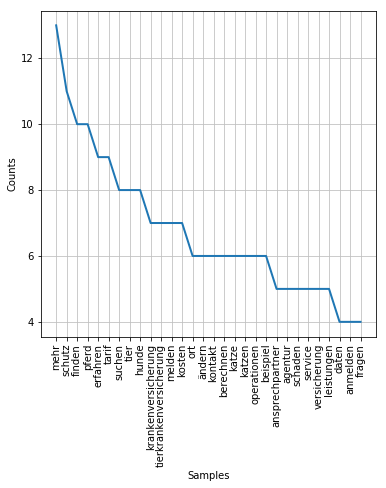

Reisekrankenversicherung


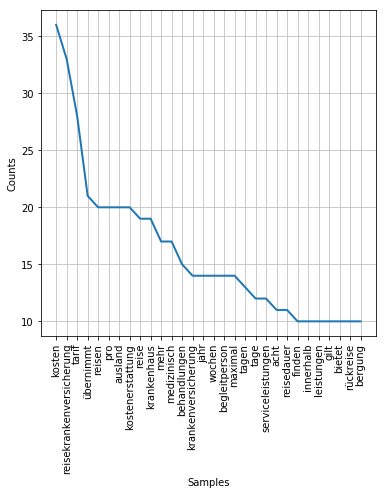

Reiserücktrittsversicherung


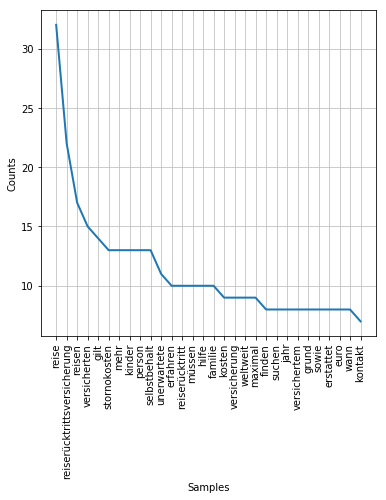

Reisegepäckversicherung


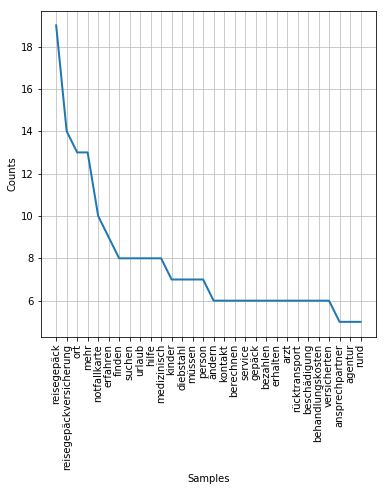

IM ÜBERBLICK


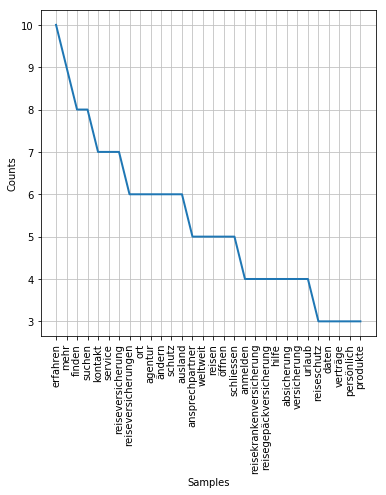

Berufsunfähigkeitsversicherung


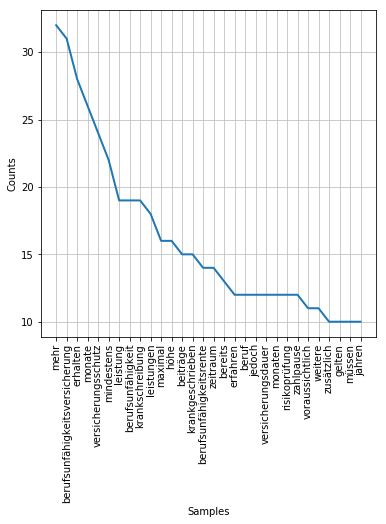

KörperSchutzPolice


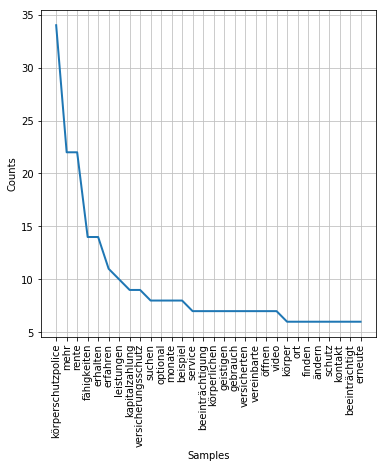

Unfallversicherung


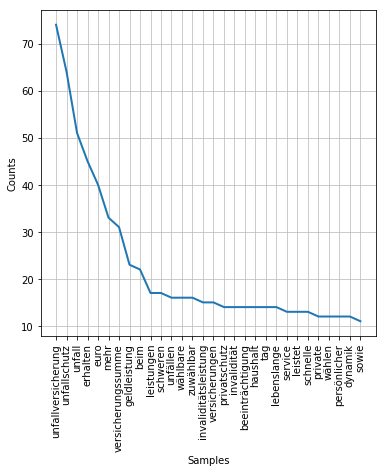

Unfallversicherung für Kinder


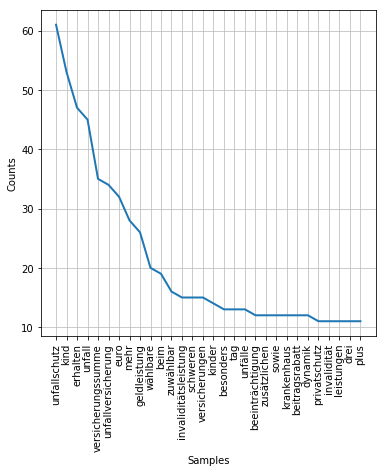

Private Rentenversicherung


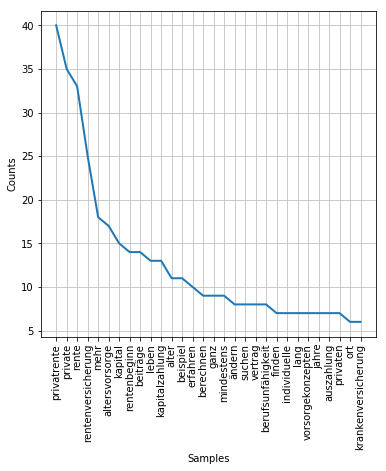

Riester-Rente


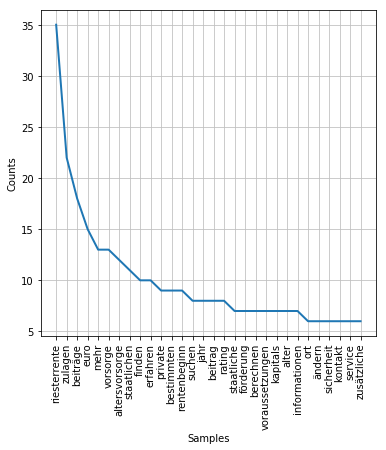

Rürup-Rente


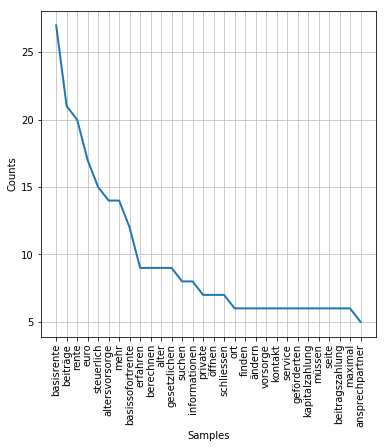

FOURMORE


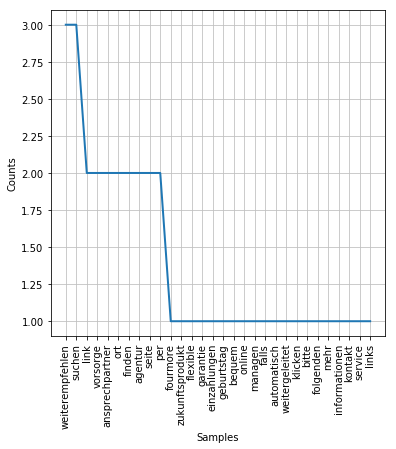

Betriebliche Altersvorsorge


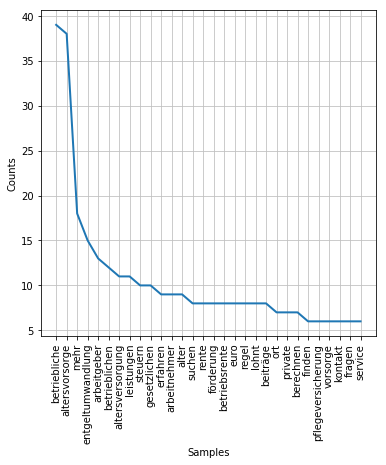

IM ÜBERBLICK


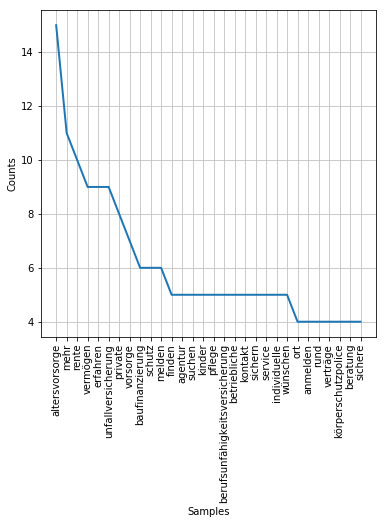

Risikolebensversicherung


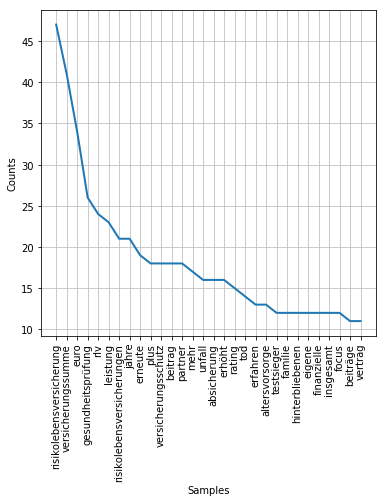

Sterbegeldversicherung


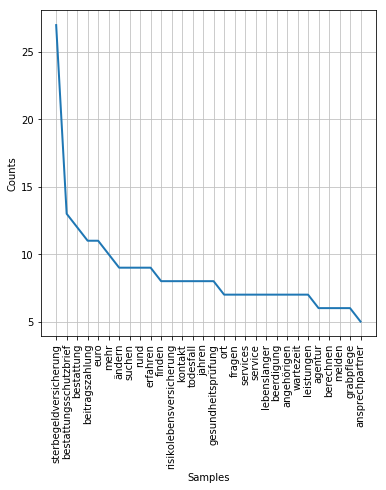

ParkDepot


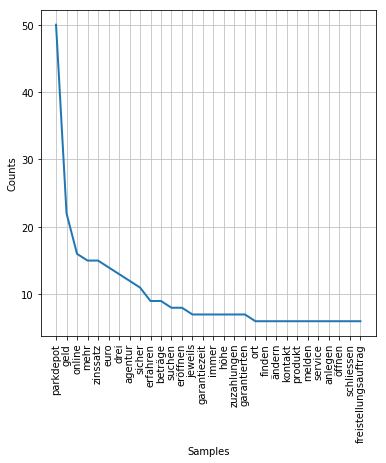

SchatzBrief


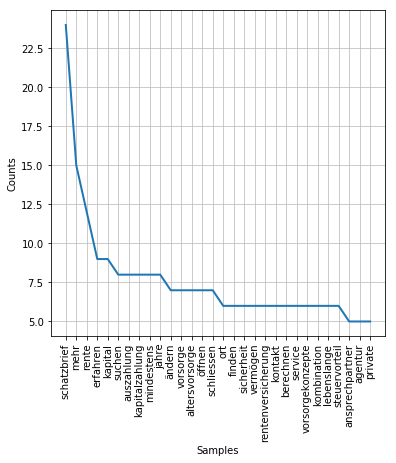

Agentursuche


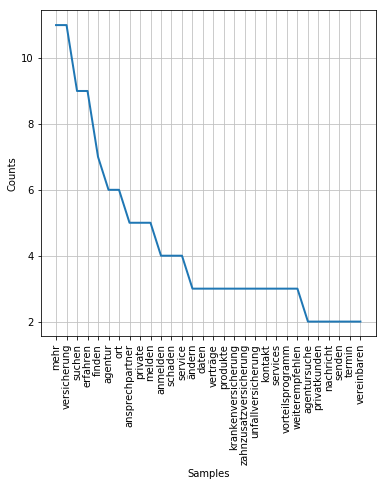

Vor Ort beraten werden


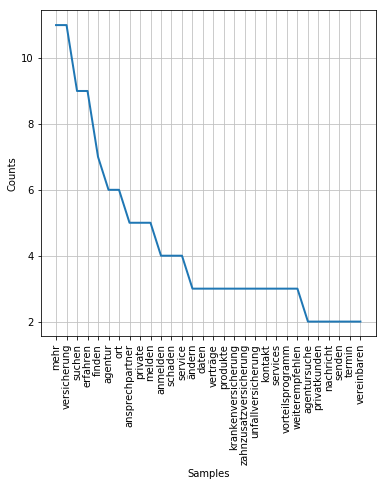

Online-Beratung


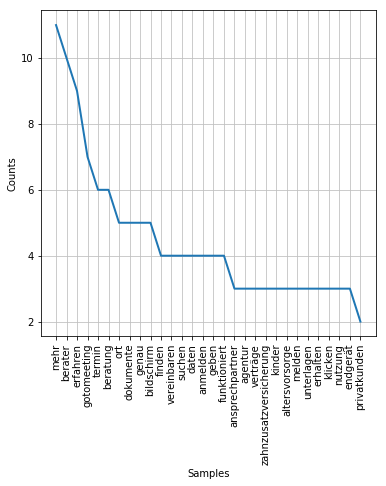

Hotlines und Adressen


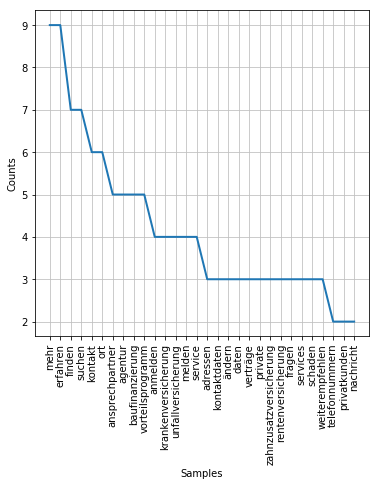

Online-Kontakt


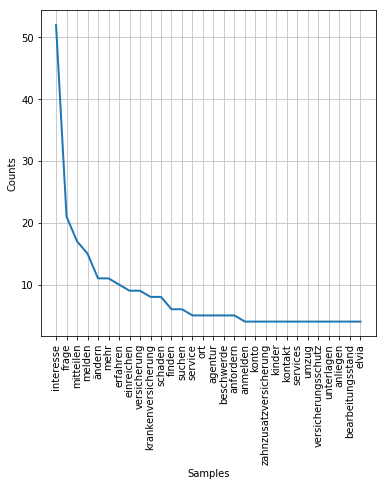

Forum "Allianz hilft"


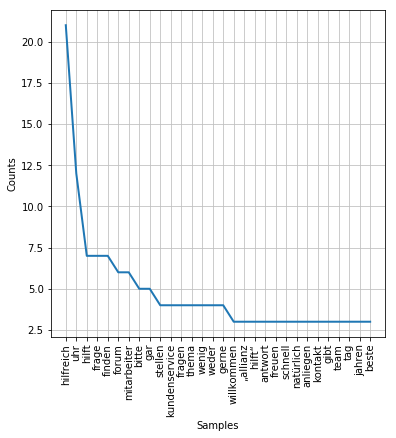

IM ÜBERBLICK


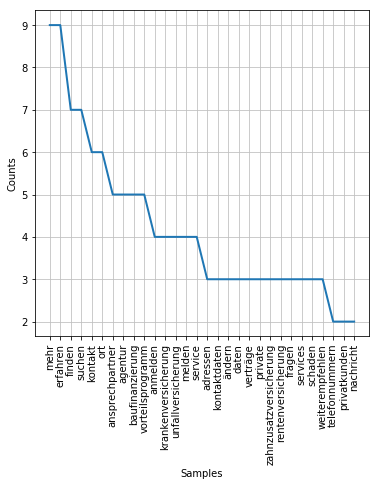

Produktfinder


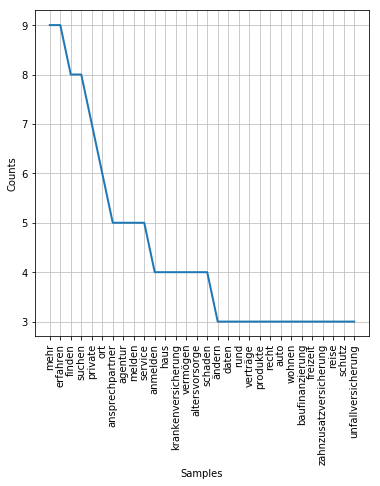

Produkte berechnen


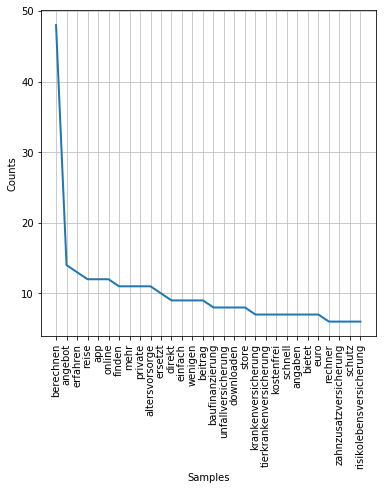

Häufige Fragen


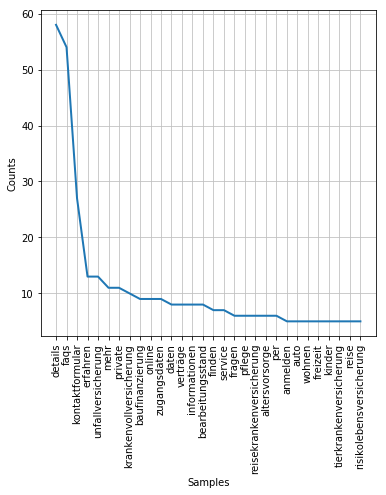

IM ÜBERBLICK


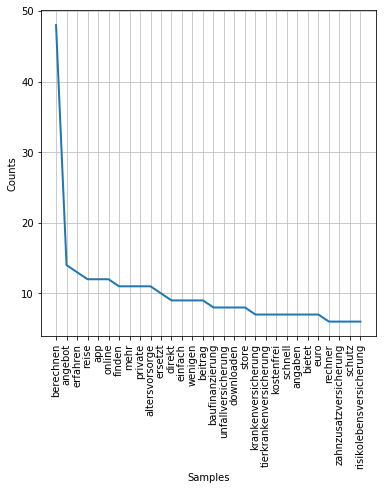

Mehr Erfahren


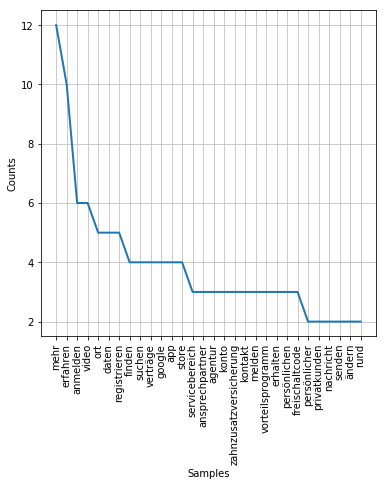

Verträge & Angebote


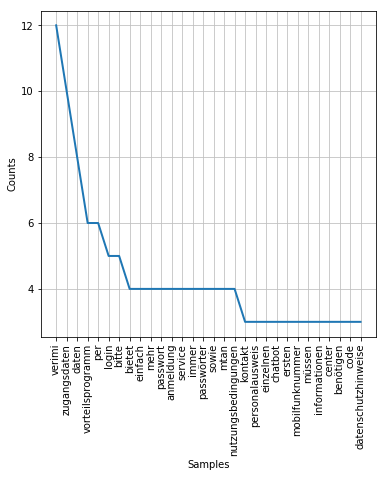

Postfach


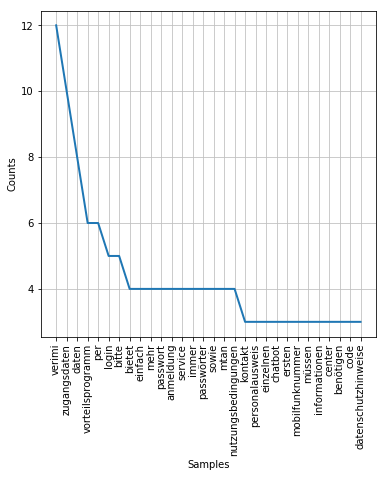

Dokumente


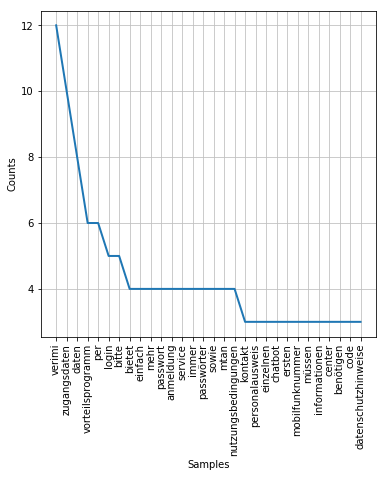

Schaden


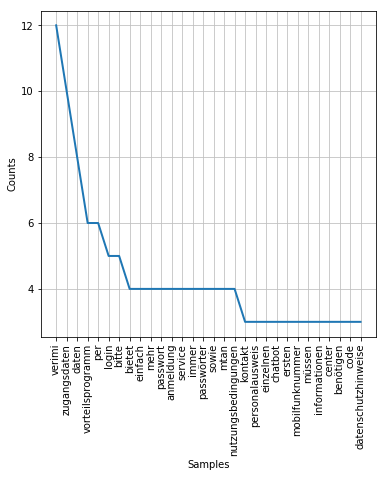

Leistung


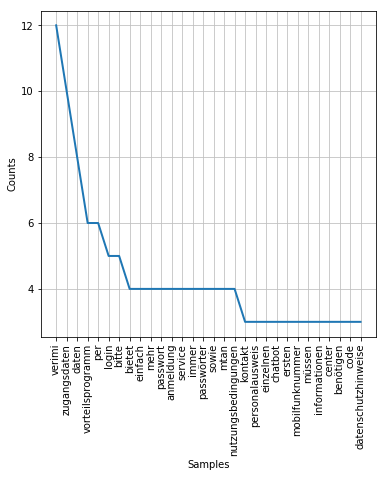

Meine Daten


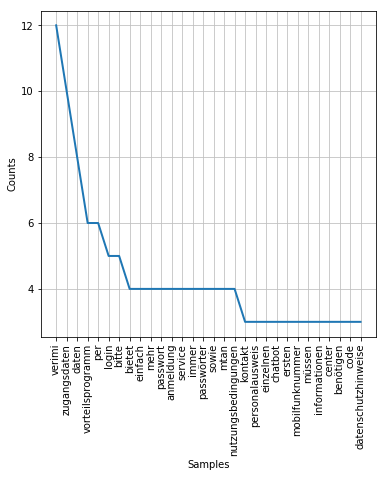

Schaden melden


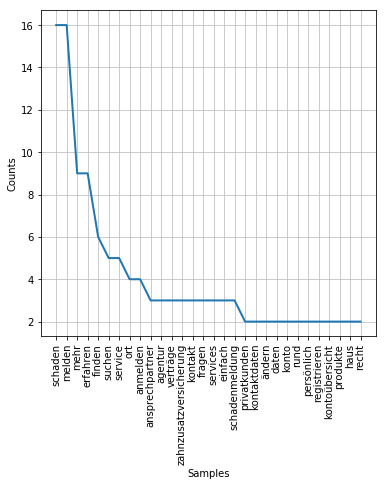

Arztrechnung einreichen


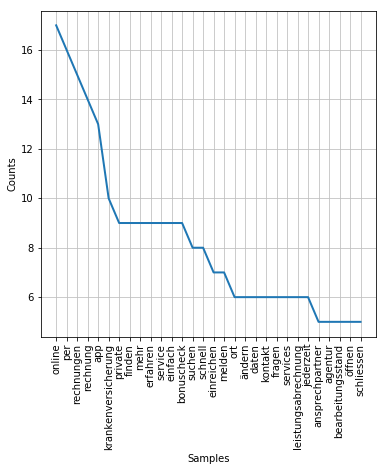

Umzug melden


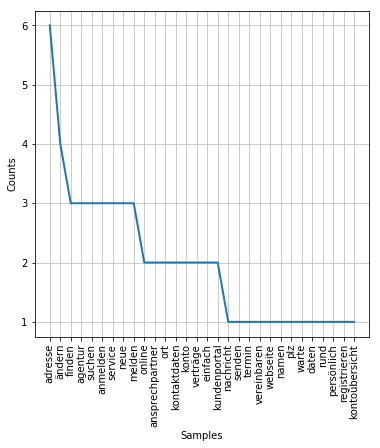

Bankverbindung ändern


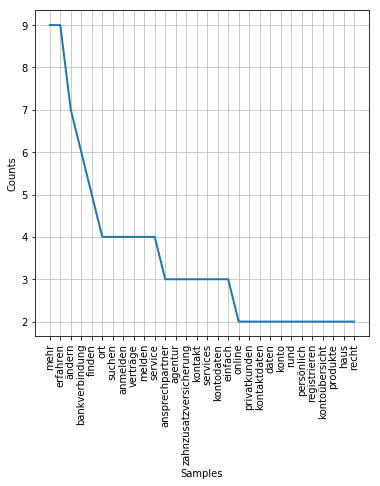

IM ÜBERBLICK


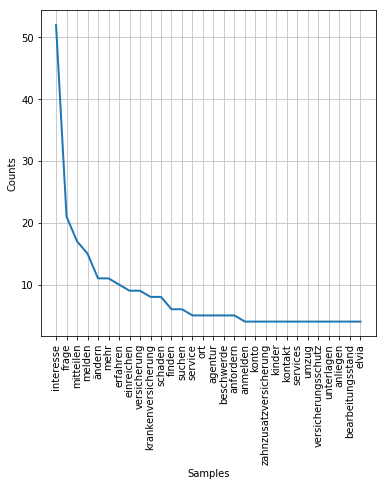

Tickets


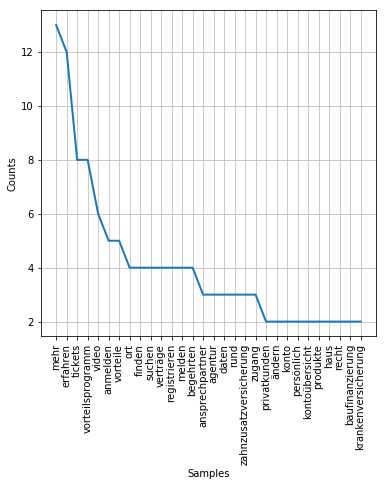

Gewinnspiele


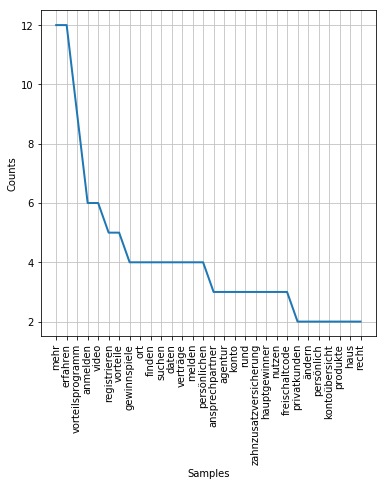

Einkaufsvorteile


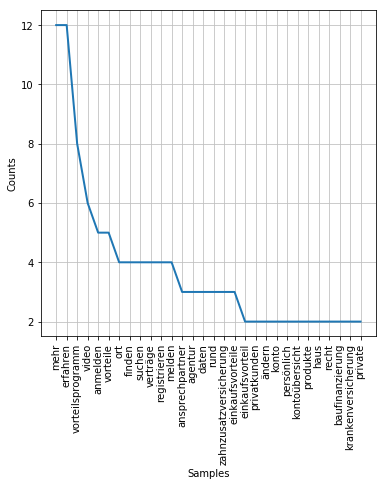

Jahresgeschenke


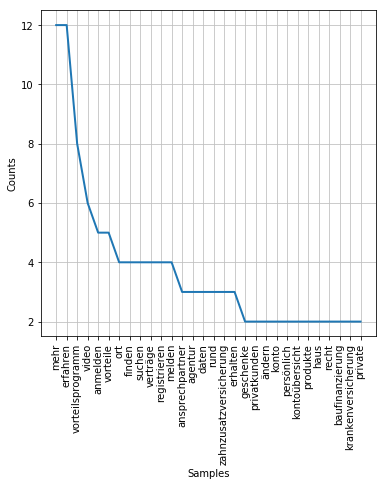

IM ÜBERBLICK


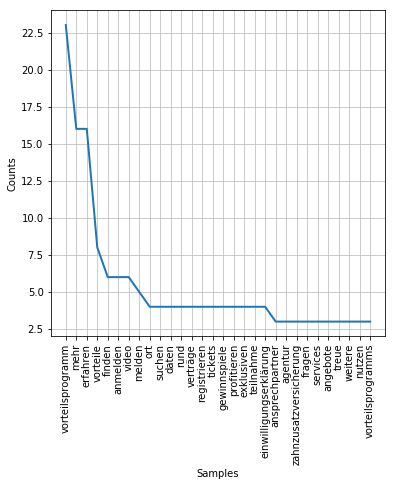

Produkt finden


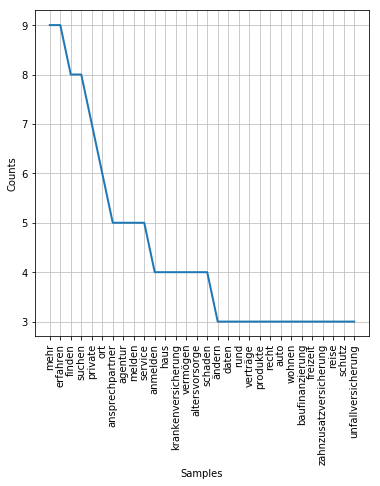

Telefonnummer finden


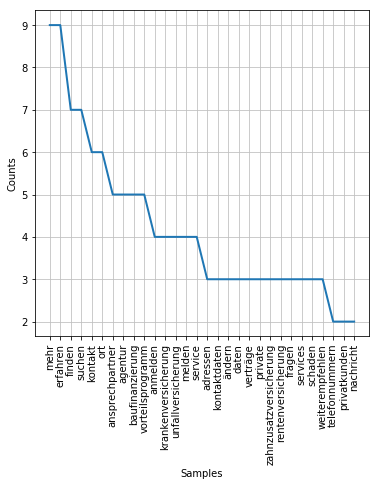

Service finden


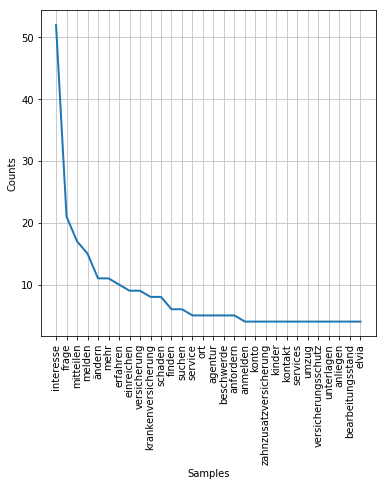

Live-Chat starten


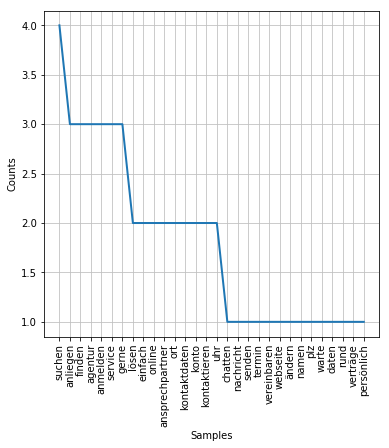

JETZT ANFORDERN


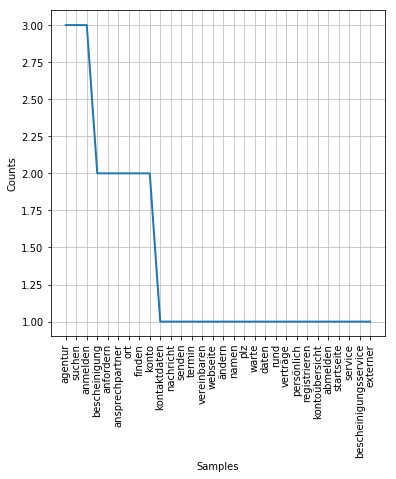

FRAGEN STELLEN


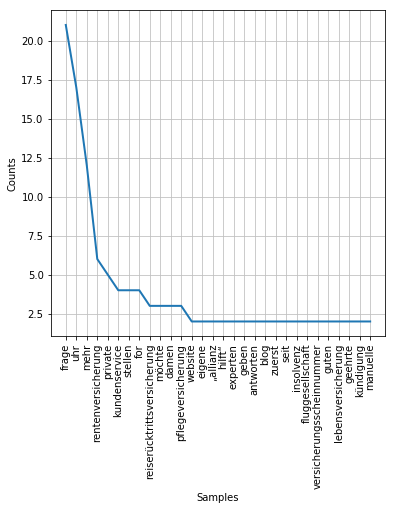

ANTWORTEN finden


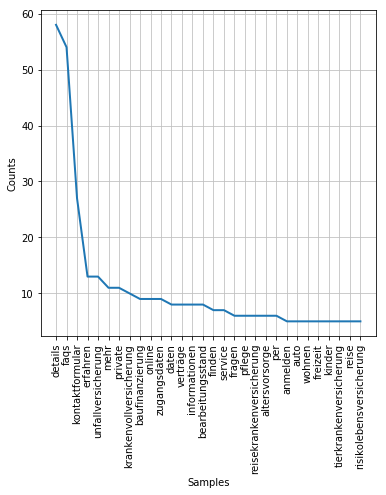

Daten ändern


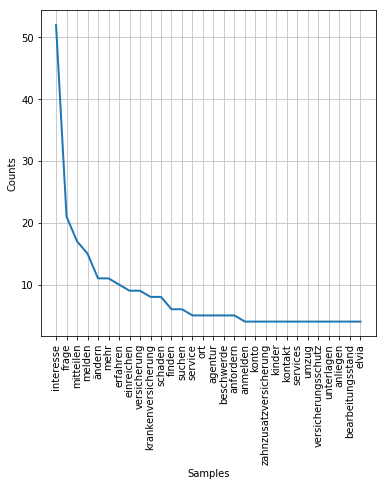

Private Haftpflichtversicherung


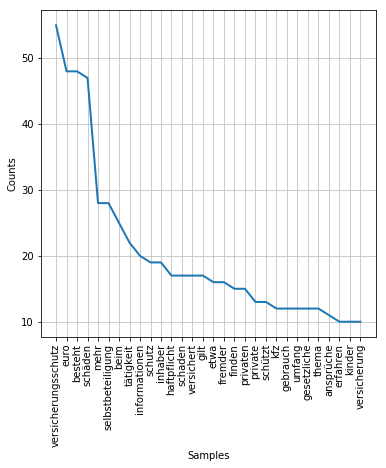

RisikoLebensversicherung


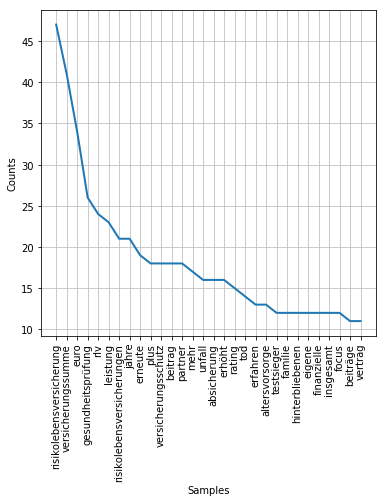

Auslandskrankenversicherung


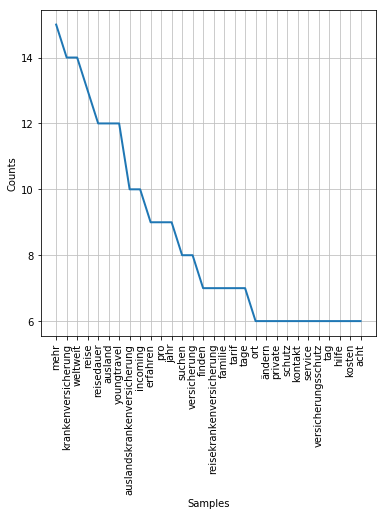

eVB Nummer Online


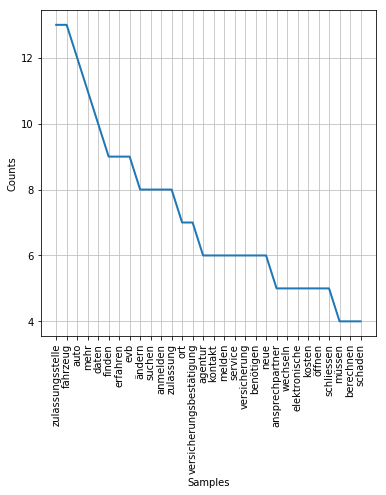

Kfz-Teilkasko


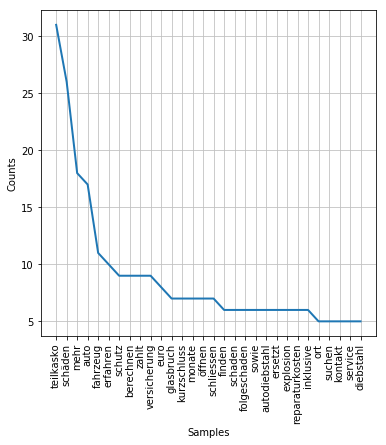

Direktversicherung


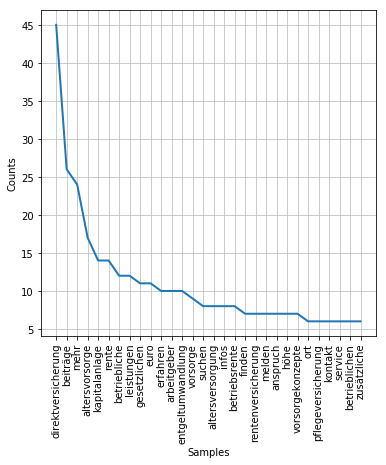

Riester Rente


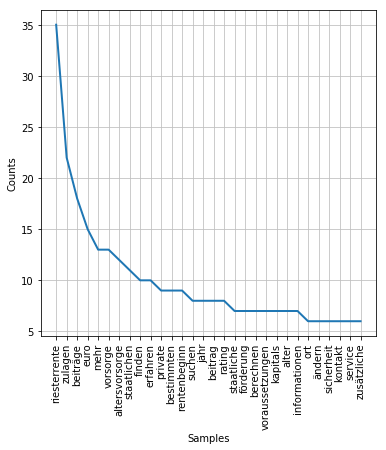

Kilometerstandsmeldung


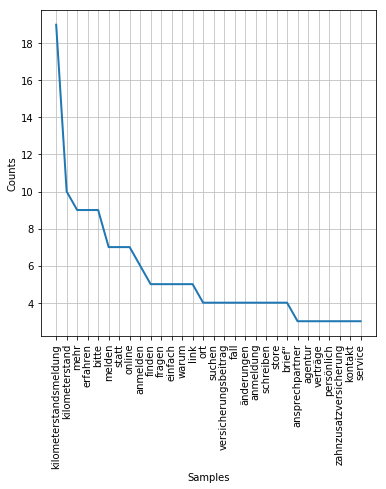

Online-Services


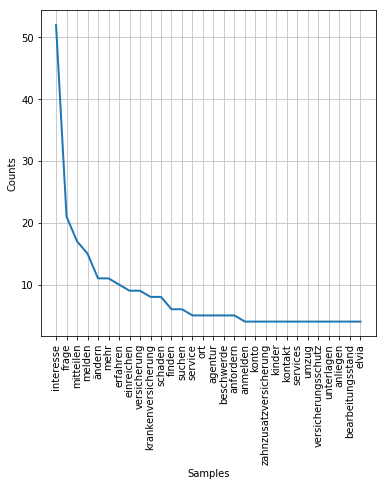

Newsletter


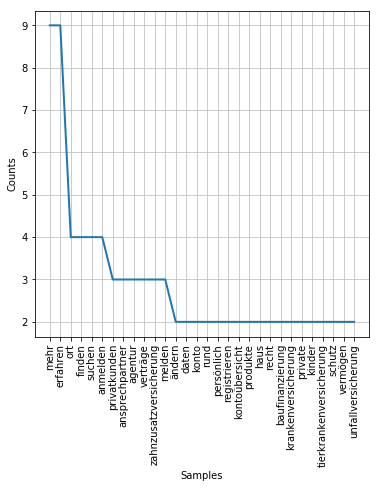

"Allianz hilft" Forum


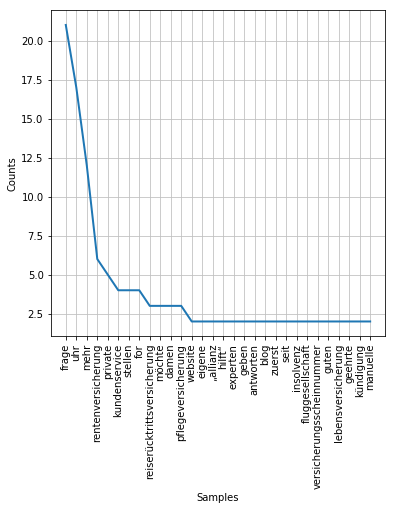

Beschwerdedialog


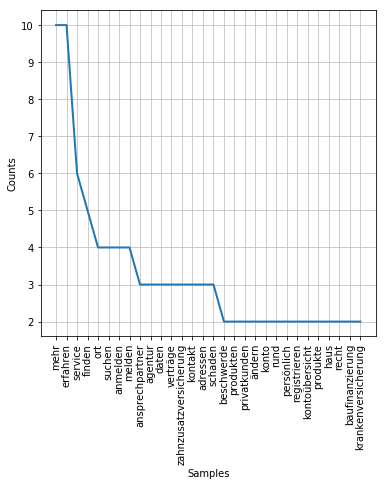

Allianz.com


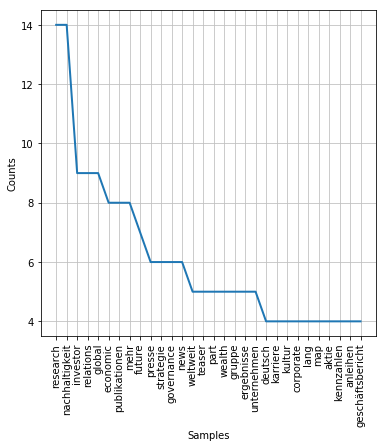

Karriere


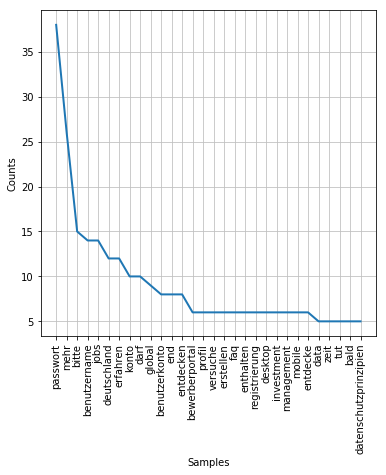

Engagement


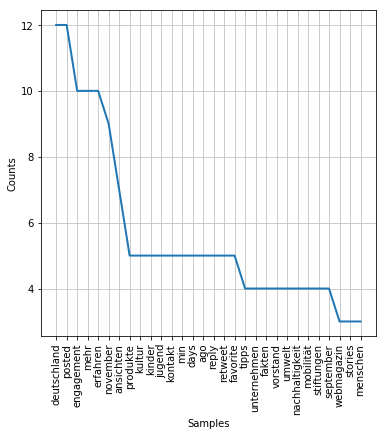

Compliance


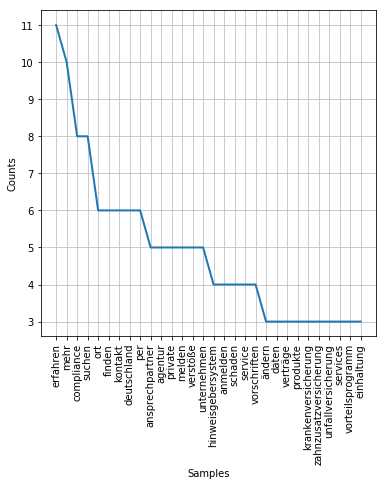

Investor Relations


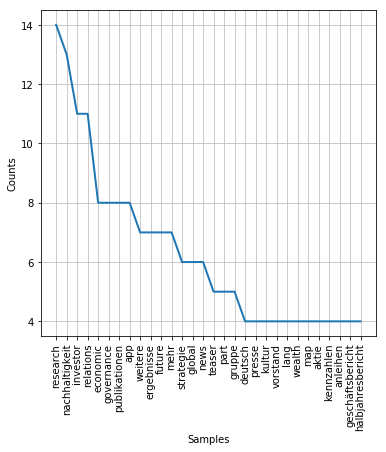

Presse


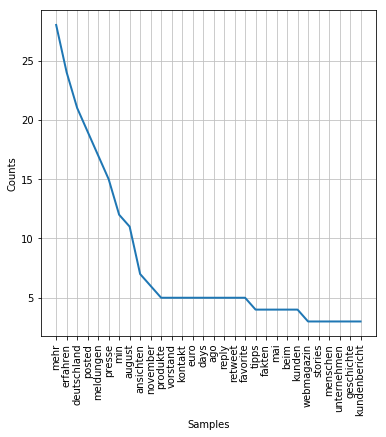

Unternehmen


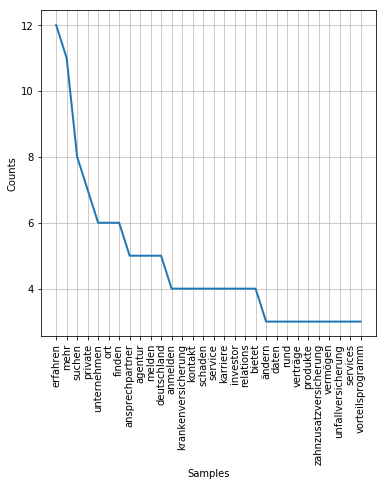

Login


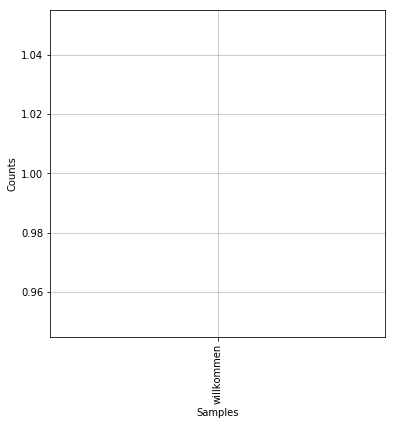

Online-Versicherungsordner


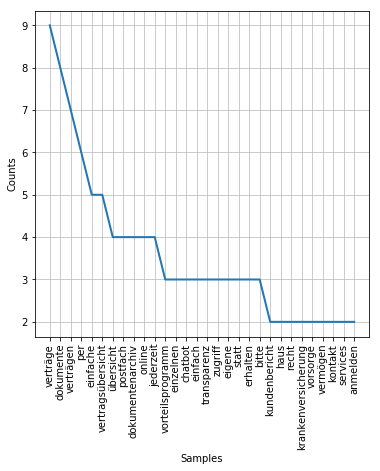

Allianz Vorteilsprogramm


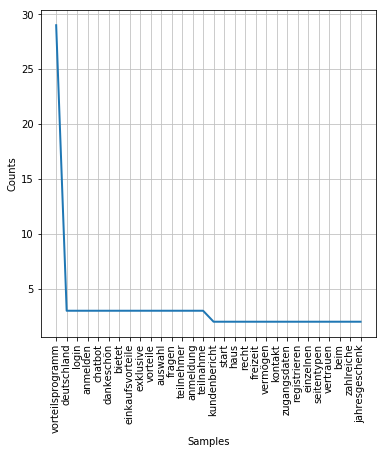

Registrierung


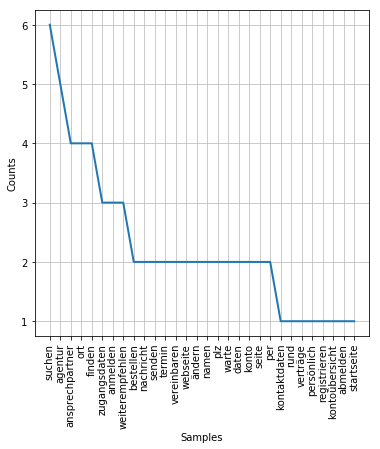

Zugangsdaten vergessen


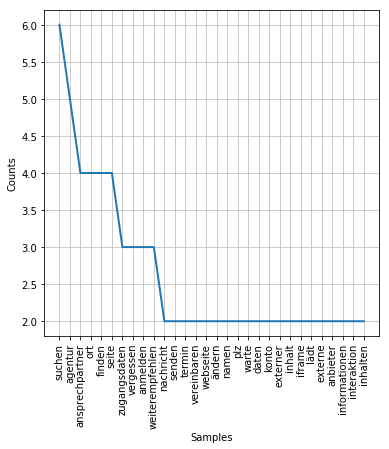

Impressum


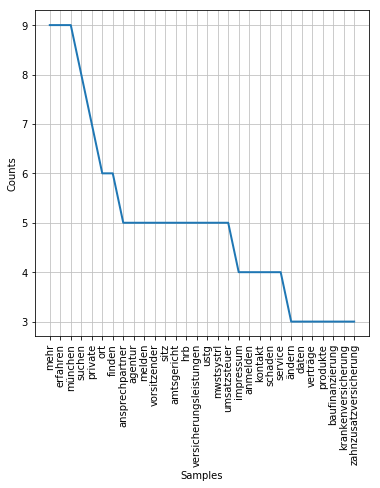

Datenschutz


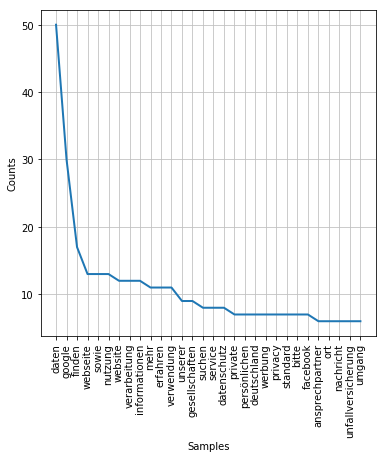

Nutzungsbedingungen


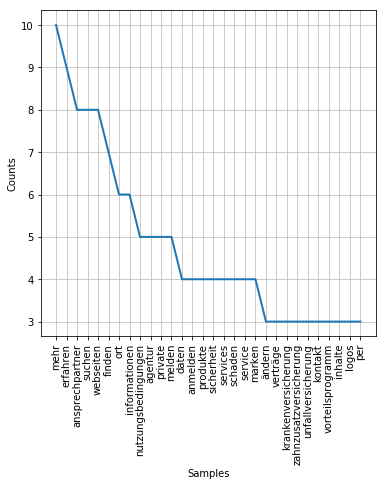

Online Rechner


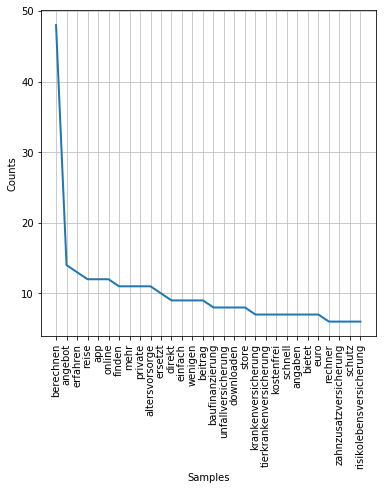

In [253]:
for i in range(df.shape[0]):
    print(df.loc[i, "Text"])
    tag_words = df.loc[i, "Words"]
    fdist = FreqDist(tag_words)
    plt.figure(figsize=(6, 6))
    fdist.plot(30, cumulative=False)
    plt.show()

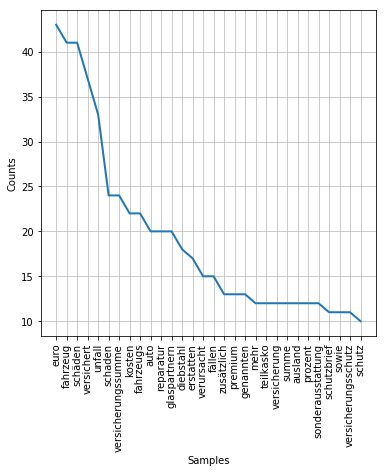

,Word,Freq
0,euro,43
1,fahrzeug,41
2,schäden,41
3,versichert,37
4,unfall,33
5,schaden,24
6,versicherungssumme,24
7,kosten,22
8,fahrzeugs,22
9,auto,20


In [221]:
stop_words = stopwords.words('german') + ["allianz", "überblick"]
tag_words = extract_text(url="https://www.allianz.de/auto/kfz-versicherung/", blacklist=blacklist, stop_words=stop_words)
fdist = FreqDist(tag_words)
plt.figure(figsize=(6, 6))
fdist.plot(30, cumulative=False)
plt.show()
f = pd.DataFrame(fdist.most_common(100), columns=["Word", "Freq"])
f[f.Freq > 3]

In [187]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

stemmed_words = []
for w in tag_words:
    stemmed_words.append(ps.stem(w))

print("Stemmed Sentence:", stemmed_words)

Stemmed Sentence: ['vorsorg', 'vermögensaufbau', 'privatkunden', 'privatkunden', 'firmenkunden', 'ansprechpartn', 'ort', 'finden', 'agentur', 'kontaktdaten', 'nachricht', 'senden', 'termin', 'vereinbaren', 'webseit', 'agentur', 'ändern', 'finden', 'ansprechpartn', 'namen', 'suchen', 'plz', 'ort', 'suchen', 'agentur', 'suchen', 'wart', 'daten', 'anmelden', 'konto', 'rund', 'verträg', 'persönlich', 'anmelden', 'anmelden', 'registrieren', 'konto', 'kontoübersicht', 'abmelden', 'produkt', 'hau', 'recht', 'auto', 'schutzbrief', 'oldtimerversicherung', 'motorradversicherung', 'hau', 'wohnen', 'hausratversicherung', 'wohngebäudeversicherung', 'baufinanzierung', 'haftpflicht', 'kombi', 'recht', 'rechtsschutzversicherung', 'verkehrsrechtsschutzversicherung', 'wechseln', 'mehr', 'erfahren', 'privatschutz', 'sicherheit', 'alltag', 'günstig', 'mehr', 'erfahren', 'gesundheit', 'freizeit', 'krankenversicherung', 'privat', 'krankenversicherung', 'krankenzusatzversicherung', 'krankenhauszusatzversiche

In [193]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

lem_words = []
for w in tag_words:
    lem_words.append(lem.lemmatize(w, 'v'))

print("Stemmed Sentence:", lem_words)

Stemmed Sentence: ['vorsorge', 'vermögensaufbau', 'privatkunden', 'privatkunden', 'firmenkunden', 'ansprechpartner', 'ort', 'finden', 'agentur', 'kontaktdaten', 'nachricht', 'senden', 'termin', 'vereinbaren', 'webseite', 'agentur', 'ändern', 'finden', 'ansprechpartner', 'namen', 'suchen', 'plz', 'ort', 'suchen', 'agentur', 'suchen', 'warte', 'daten', 'anmelden', 'konto', 'rund', 'verträge', 'persönlich', 'anmelden', 'anmelden', 'registrieren', 'konto', 'kontoübersicht', 'abmelden', 'produkte', 'haus', 'recht', 'auto', 'schutzbrief', 'oldtimerversicherung', 'motorradversicherung', 'haus', 'wohnen', 'hausratversicherung', 'wohngebäudeversicherung', 'baufinanzierung', 'haftpflicht', 'kombi', 'recht', 'rechtsschutzversicherung', 'verkehrsrechtsschutzversicherung', 'wechseln', 'mehr', 'erfahren', 'privatschutz', 'sicherheit', 'alltag', 'günstig', 'mehr', 'erfahren', 'gesundheit', 'freizeit', 'krankenversicherung', 'private', 'krankenversicherung', 'krankenzusatzversicherung', 'krankenhauszu

<FreqDist with 393 samples and 708 outcomes>
[('Allianz', 19), ('IM', 18), ('ÜBERBLICK', 18), ('Sie', 16), ('.', 16), ('Mehr', 9), ('finden', 8), ('suchen', 8), ('Service', 7), (',', 6), ('Ort', 6), ('Agentur', 6), ('Meine', 6), ('erfahren', 6), ('Ansprechpartner', 5), ('Daten', 5), ('Ihre', 5), ('&', 5), ('Kfz-Versicherung', 5), ('Private', 5), ('%', 5), ('ändern', 4), ('Nach', 4), ('Anmelden', 4), ('Ihr', 4), ('Schutz', 4), ('Kontakt', 4), ('Produkt', 4), ('Schaden', 4), ('melden', 4)]


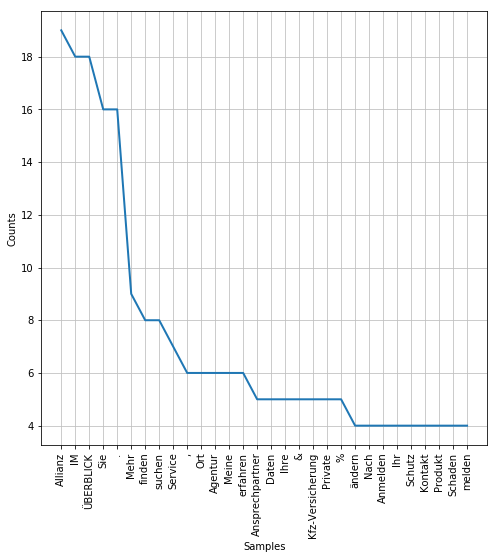

In [178]:
import requests
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

url = 'https://www.allianz.de'
res = requests.get(url)
html_page = res.content
soup = BeautifulSoup(html_page, 'html.parser')
text = soup.find_all(text=True)

output = ''

for t in text:
    if t.parent.name not in blacklist:
        output += '{} '.format(t.strip())

tokenized_word = word_tokenize(output, language="german")
tokenized_word = np.array([word for word in tokenized_word if word not in stop_words])

fdist = FreqDist(tokenized_word)
print(fdist)
print(fdist.most_common(30))
plt.figure(figsize=(8, 8))
fdist.plot(30, cumulative=False)
plt.show()

In [179]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

stemmed_words = []
for w in tokenized_word:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", tokenized_word)
print("Stemmed Sentence:", stemmed_words)

Filtered Sentence: ['Versicherung' ',' 'Vorsorge' 'Vermögensaufbau' '|' 'Allianz' '/*'
 'properties.logoLinkId' '*/' 'Privatkunden' 'Privatkunden' 'Firmenkunden'
 'Ansprechpartner' 'Ort' 'finden' 'Agentur' 'Kontaktdaten' 'Nachricht'
 'senden' 'Termin' 'vereinbaren' 'Zur' 'Webseite' 'Agentur' 'ändern'
 'Finden' 'Sie' 'Ansprechpartner' 'Ihrer' 'Nähe' '.' 'Nach' 'Namen'
 'suchen' 'Nach' 'PLZ' 'Ort' 'suchen' 'Agentur' 'suchen' 'Warte' 'Daten'
 '...' 'Anmelden' 'Mein' 'Konto' 'Meine' 'Allianz' '/*' 'Temporary'
 'change' 'GGMS-7100' ':' 'Reuse' 'of' 'existing' 'class'
 'c-agency-context-flyout__search-agency_header__text' '*/' 'Meine'
 'Allianz' 'Ihr' 'Online-Portal' 'rund' 'Ihre' 'Verträge' '–' 'persönlich'
 'sicher' '.' 'Anmelden' 'Anmelden' 'Registrieren' 'Mein' 'Konto'
 'Kontoübersicht' 'Abmelden' '/*' 'Mobile' 'Buttons' '*/' 'Produkte'
 'Auto' ',' 'Haus' '&' 'Recht' 'Auto' 'Kfz-Versicherung' 'Schutzbrief'
 'Oldtimerversicherung' 'Motorradversicherung' 'IM' 'ÜBERBLICK' 'Haus'
 'Wohnen' '

In [151]:
data = extract_links(blacklist=blacklist)

In [156]:
data["Words"] = data.apply(lambda r: extract_text(url=r.URL, blacklist=blacklist, stop_words=stop_words), axis=1)

In [159]:
data.to_csv(path_or_buf="test.csv", index=False)

In [141]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.allianz.de'
res = requests.get(url)
html_page = res.content
soup = BeautifulSoup(html_page, 'html.parser')
text = soup.find_all(text=True)

output = ''
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    'style',
]

for t in text:
    if t.parent.name not in blacklist:
        output += '{} '.format(t.strip())

output = output.split(" ")
tag_words = []
comment = False
for out in output:
    if out == "/*":
        comment = True
    if out == "*/":
        comment = False
    if not comment:
        regex = re.compile('[@_!#$%^&*()€"<>?/\|.©+=},{~:]')  
        if regex.search(out) == None and out != "" and len(out) > 2 and '–' not in out and "-" not in out and "\xa0" not in out and "\xad" not in out and not hasNumbers(out):
            tag_words.append(out.lower())